# Settings...

In [1]:
import torch
from matplotlib import pyplot as plt, axes
from model.model import MTN, MTN_auxi
from utils.utils import makeInput, to_np
import torch.utils.data.distributed
import torch.nn.parallel
import torch.utils.data
import seaborn as sns
import pandas as pd
import numpy as np
import torch.optim
import pickle
import pprint
import torch

# Section A. HeatMap
### Contents
- A.0 Function
    - drawHeatmap : 히트맵 그리는 펑션,,,
- A.1 Psuedo Visualization
    - 임의의 샘플에 대한 시각화
- A.2 MTN_auxi Visualization
    - MTN_auxi에 주어진 임의의 Loss에 따른 Attention Map 시각화
- A.3 Training Attention MAP Visualization
    - 훈련기간 중 생성된 attention map에 대한 시각화

### A.0 Function

In [2]:
def drawHeatmap(matrixes, col=1, title=[], fmt=1, p=False,
         vmin=None, vmax=None, xticklabels=False, yticklabels=False,
         linecolor=None, linewidths=0.1, fontsize=30,
         cmap="Greys", cbar=True):


    row = (len(matrixes) - 1) // col + 1
    annot = True if fmt > 0 else False
    if p:
        print("|- Parameter Information")
        print("  |- Matrix     : 입력 값")
        print("  |- title      : 컬럼별 제목")
        print("  |- col        : 컬럼 갯수")
        print("  |- p          : 정보 출력")
        print("  |- vmin/vmax  : 히트맵 최소/최대 값")
        print("  |- linecolor  : black, ...   ")
        print("  |- linewidths : 1.0...   ")
        print("  |- fmt        : 숫자 출력 소숫점 자릿 수")
        print("  |- cmap        : Grey")
        print("  |- cbar        : 오른쪽 바 On/Off")
        print("  |- xticklabels : x축 간격 (False, 1,2,...)")
        print("  |- yticklabels : y축 간격 (False, 1,2,...)")
        print()
        print("|- Graph Information")
        print("  |- row : {}, col : {}".format(row, col))
        print("  |- height : {}, width : {}".format(row * 8, col * 8))
    # if title:
        # title = title + list(range(len(title), len(matrixes) - len(title)))
    fig, axes = plt.subplots(nrows=row, ncols=col, squeeze=False)
    fig.set_size_inches(col * 8, row * 8)

    for e, matrix in enumerate(matrixes):
        if type(matrix) == torch.Tensor:
            matrix = matrix.detach().cpu().numpy()
        ax = axes[e // col][e % col]
        sns.heatmap(pd.DataFrame(matrix), annot=annot, fmt=".{}f".format(fmt), cmap=cmap
                    , vmin=vmin, vmax=vmax, yticklabels=yticklabels, xticklabels=xticklabels
                    , linewidths=linewidths, linecolor=linecolor, cbar=cbar, annot_kws={"size": fontsize / np.sqrt(len(matrix))}
                    , ax=ax)
        if title:
            ax.set(title="{} : {}".format(title, e))
        ax.spines[["bottom", "top", "left", "right"]].set_visible(True)
    plt.show()
    
def makeSample(shape, min=None,max=None, dataType=int, outputType=np, columns=None):
    if dataType == int:
        d = np.random.randint(min, max, size=shape)
    elif dataType ==float:
        d = np.random.uniform(low=min, high=max, size=shape)

    if outputType == np:
        return d
    elif outputType == pd:
        return pd.DataFrame(d, columns=None)
    elif outputType == torch:
        return torch.from_numpy(d)
    
def rangeBlock(block, vmin=0, vmax=5):
    loss = torch.arange(vmin, vmax, (vmax - vmin) / block, requires_grad=False).unsqueeze(dim=1)
    return loss

def information(args):
    task = "RETRIEVAL" if args.eval_task[0] == 1 else "CAPTIONING"
    print("|- TASK INFORMATION")
    print("  |- TASK     : ", task)
    print("  |- DATATYPE : ", args.datatype.upper())

    
def getInfo(path, epoch, p=True):
    with open("{}/info_{}.pickle".format(path, epoch), 'rb') as f:
        info = pickle.load(f)
    return info


### A.1 Psuedo Visualization

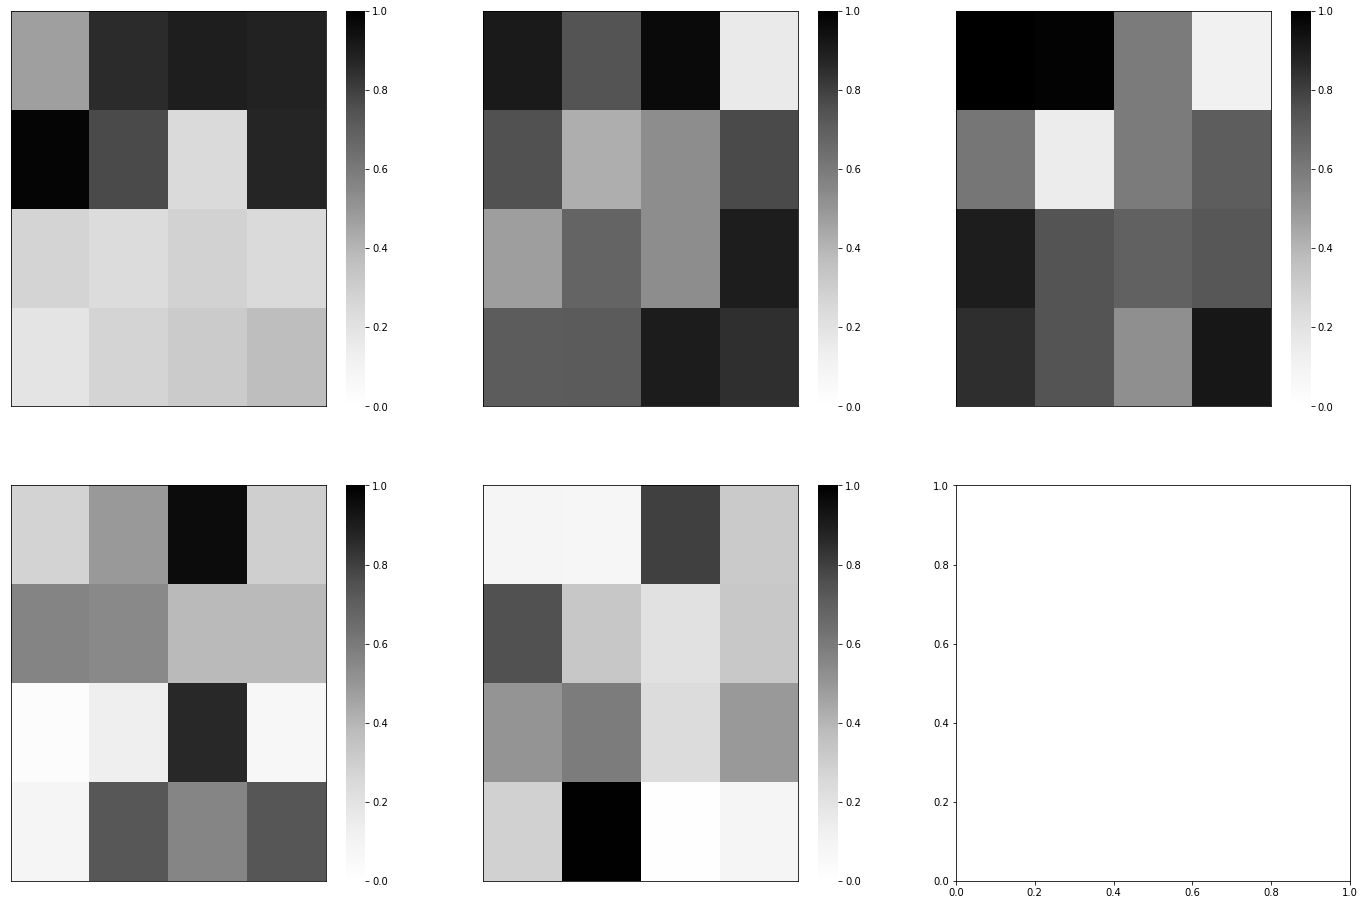

In [3]:
pp = makeSample((5,4,4), 0, 1, dataType=float, outputType=np)
drawHeatmap(pp, vmin=0, vmax=1, col=3, fmt=False, p=False)

### A.2 Visual ATTENTION MAP Using Psuedo Loss

In [5]:
############### Type 수정 필요!!!!!! ###############


# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files" 
# YOUCOOK CAPTIONING : 30 Epochs
path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files"

epochs = 3      # 최종 에포크 갯수
term = 1         # 보여줄 간격
view_type = 1    # [0 : 임의의 로스, 1 : 0 ~ 5]
losses = [torch.Tensor([1,1,2,2,3,3,1,1]).unsqueeze(1)]
vnet_T_type = 0  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]


info = getInfo(path, 0)
args = info["args"]
net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()

information(args)


result = []
for e in range(0, epochs, term):
    with torch.no_grad():
        if view_type:
            losses = rangeBlock(500, 0, 5).reshape(-1,1,1).repeat(1,8,1)
        net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, e), map_location=torch.device("cpu")))
        temps = []
        for loss in losses:
            temps.append(to_np(net(loss, vnet_T_type=vnet_T_type)[1])) # (1,8,8)
            
        result.append(np.concatenate(temps, axis=0))
result = np.stack(result)

# result.shape
drawHeatmap(np.reshape(result[:,:,:],(-1,8,8)), col=3, fmt=False, p=False)

|- TASK INFORMATION
  |- TASK     :  RETRIEVAL
  |- DATATYPE :  YOUCOOK


ValueError: Image size of 1728x288000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1728x288000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1728x288000 with 1501 Axes>

### A.3 Visualize ATTENTION MAP Using TRAINING ATTENTION INFO

In [3]:
import pickle
path = "/data/project/rw/joonmyung/EX1.4.2/wandb/run-20220227_003705-2jrykewc/files"
with open("{}/info_0.pickle".format(path), 'rb') as f:
    info = pickle.load(f)
# args = torch.load("args.pt".format(path))
args = info["args"]
atten_maps = info["atten_maps"]

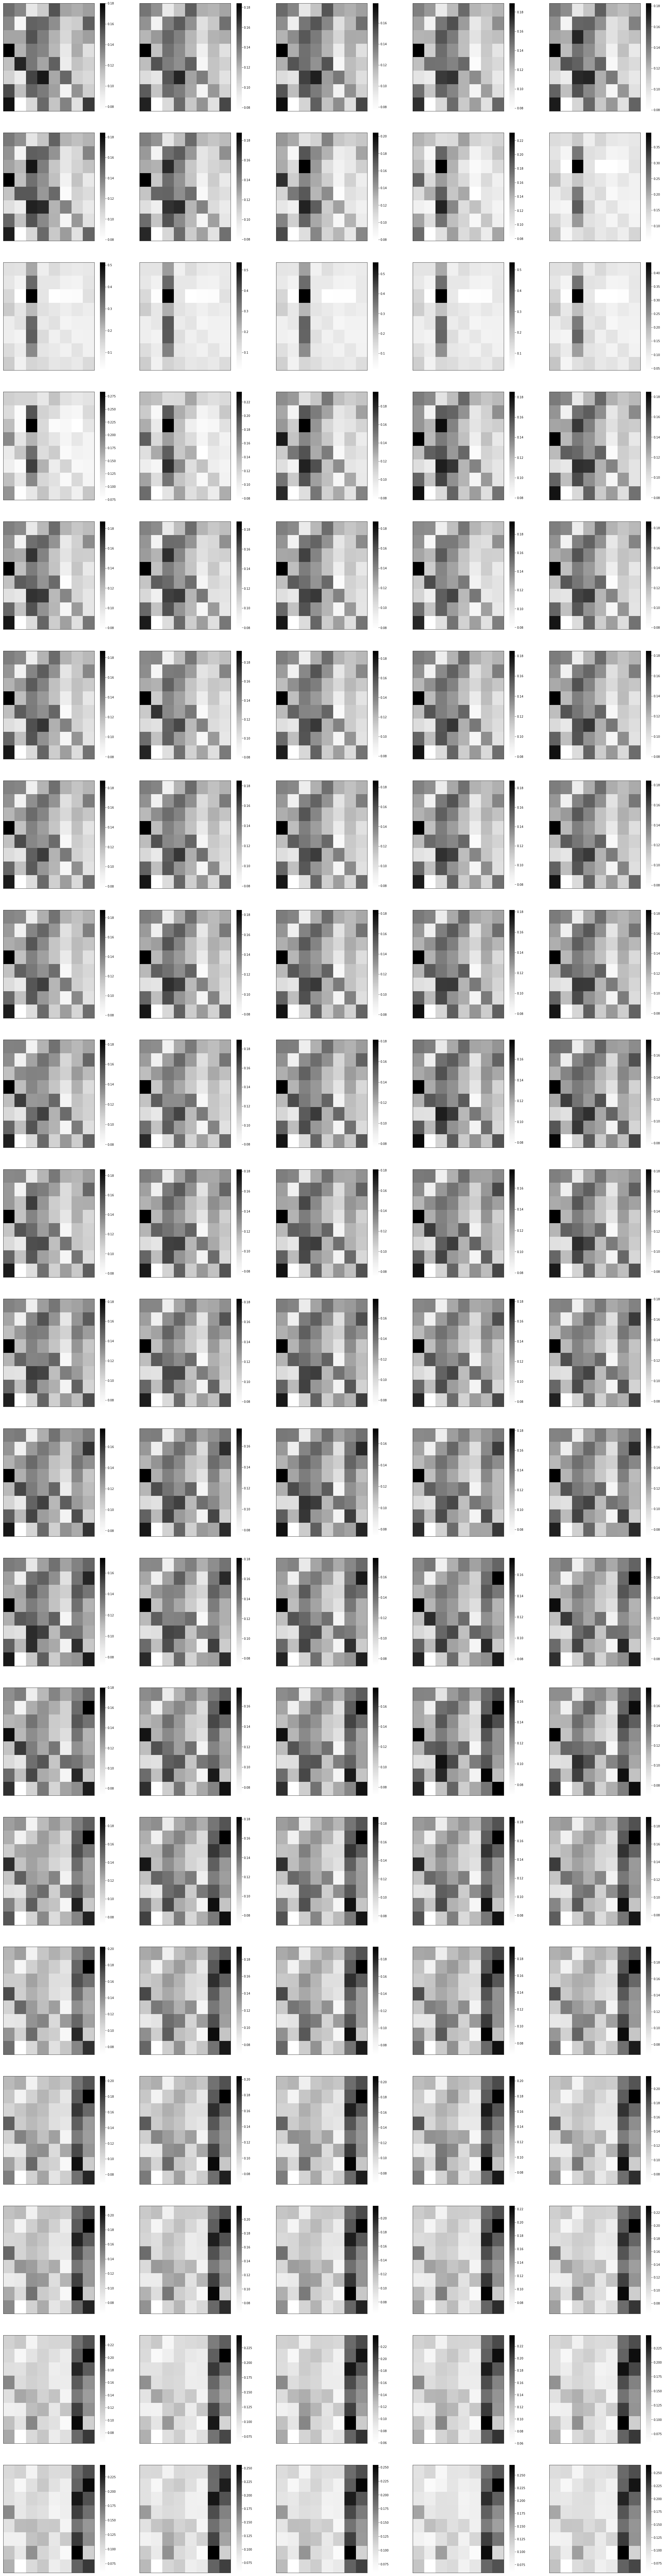

In [4]:
index = np.arange(0,100,1)
drawHeatmap(to_np(torch.cat(atten_maps))[index], col=5, fmt=False, p=False) # (ALL STEP, T, T) → (SELECT, T, T)

### A.4 Attention MAP Visualization With Loss

|- TASK INFORMATION
  |- TASK     :  RETRIEVAL
  |- DATATYPE :  YOUCOOK


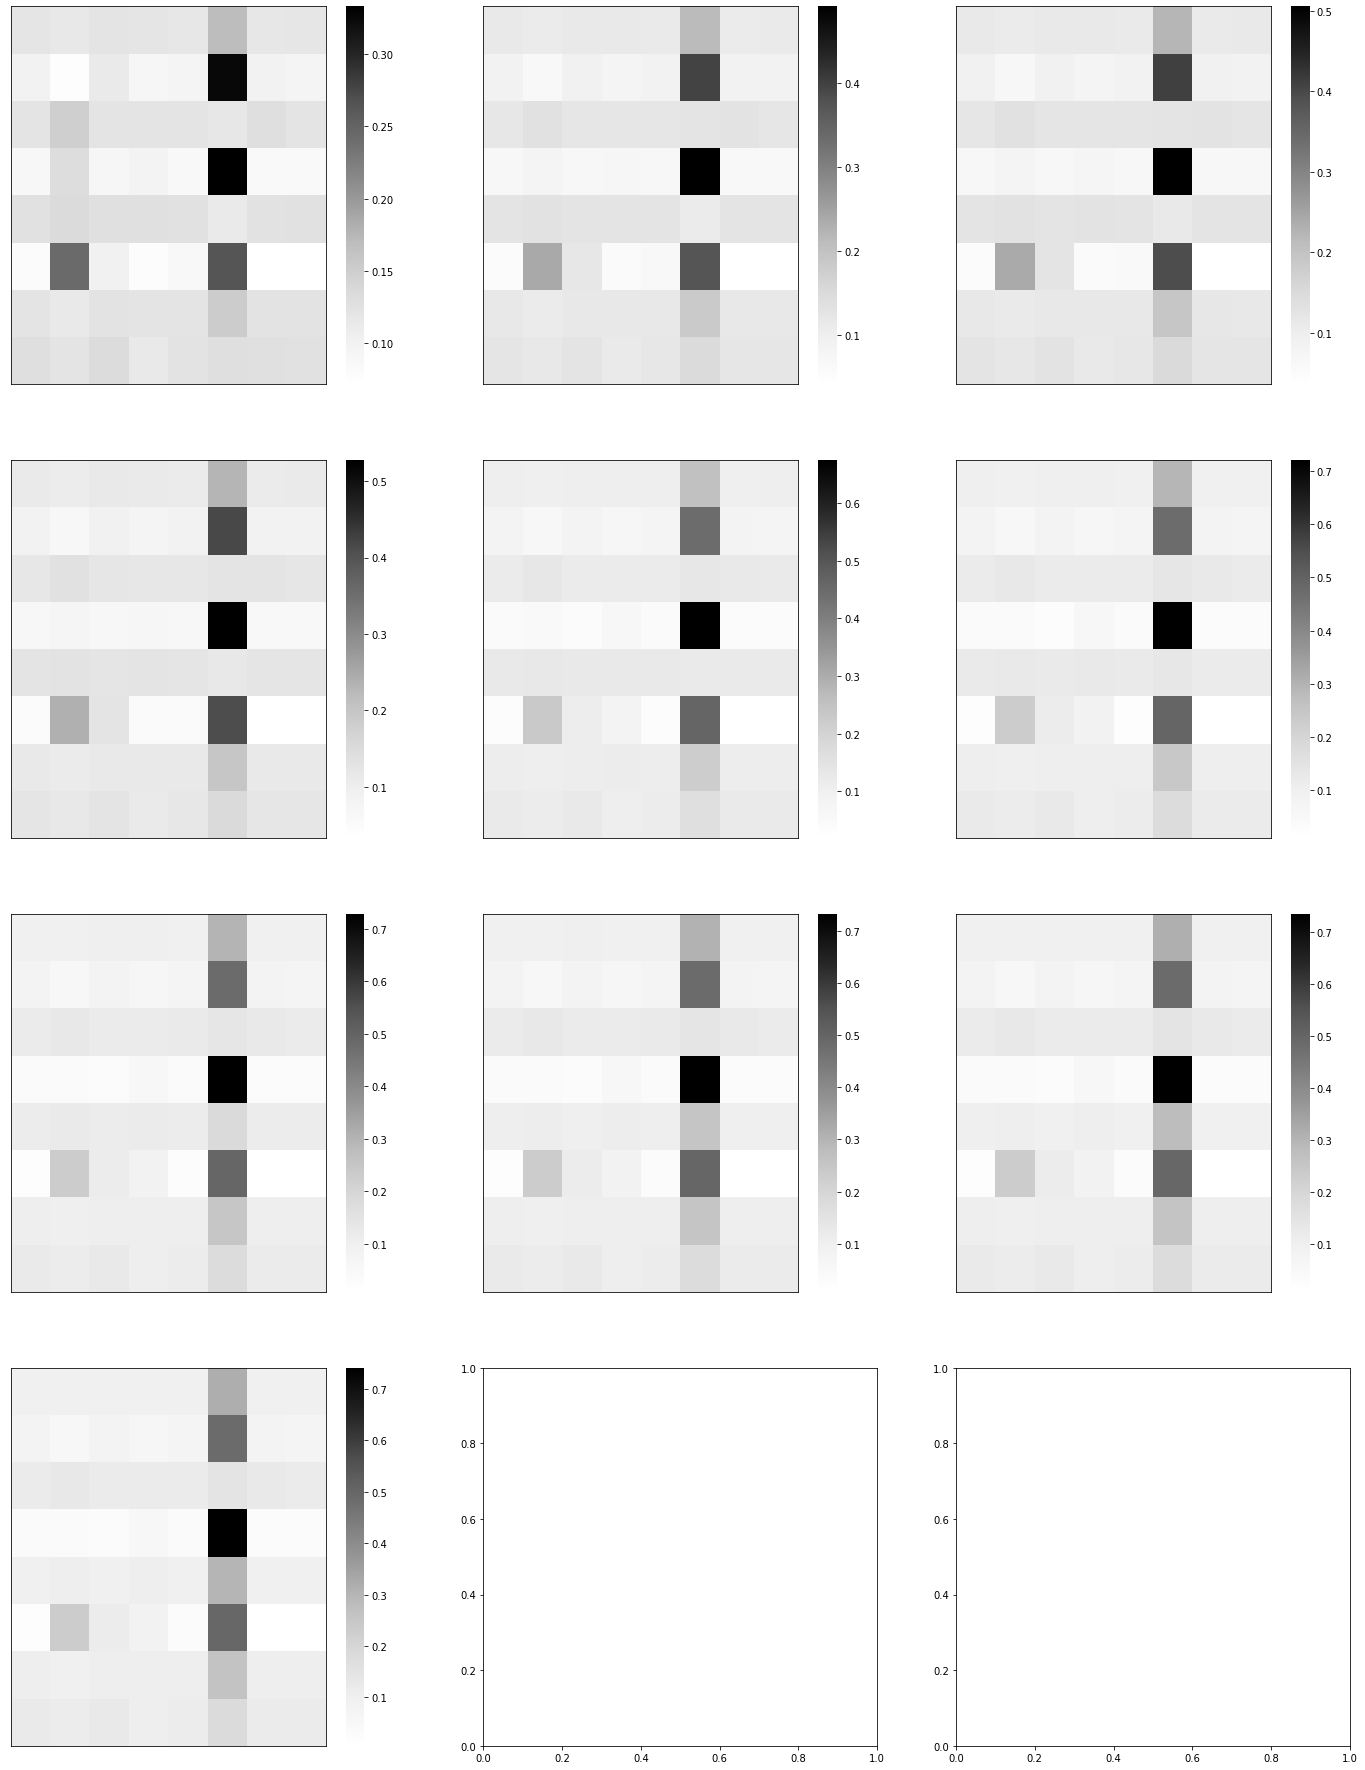

In [3]:
# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_233135-23g43ptz/files" # 3

# YOUCOOK CAPTIONING : 30 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_221616-zxvio0ox/files" # 3
# path = "/data/project/rw/joonmyung/ANA3.0.0/wandb/run-20220303_171124-3owwkffg/files"
path = "/data/project/rw/joonmyung/ANA3.1.0/wandb/run-20220303_220926-kgltlvwk/files"


epochs = 30      # 최종 에포크 갯수
term =    3      # 보여줄 간격
view_type =   1  # [0 : 스텝 전체, 1 : 스텝 평균]
vnet_T_type = 2  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]
loss_fix   =  0  # [0 : range,     1 : 고정]
re=True
info = getInfo(path, 0, p=True)
args= info["args"]
information(args)

net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()


if re:
    result_a, result_l = [], []
    for e in range(0, epochs, term):
        with torch.no_grad():
            net.load_state_dict(torch.load("{}/MELTR_{}.pt".format(path, e), map_location=torch.device("cpu")))
            info = getInfo(path, e)
            if loss_fix:
                losses = [torch.Tensor([1,1,2,2,3,3,1,1]).unsqueeze(1)]
            else:
                losses = torch.stack(info["task_losses"]).unsqueeze(-1) # 

            temps = []        
            for loss in losses:
                temps.append(to_np(net(loss, vnet_T_type=vnet_T_type)[1])) # → (1,8,8)
            if view_type:
                result_a.append(np.expand_dims(np.concatenate(temps, axis=0).mean(0), axis=0))            
                result_l.append(losses.mean(dim=0).squeeze())
            else:
                result_a.append(np.concatenate(temps, axis=0))

    result_a = np.stack(result_a) # (EPOCH, STEP, TASK, TASK)

    
    
# drawHeatmap(np.reshape(result_a[:,[0],:,:], (-1,8,8)), fmt=False, col=4, p=False, title="Epoch")
# drawHeatmap(np.reshape(result_a[:,[0],:,:], (-1,8,8)), vmin=0.2, vmax=0.8, fmt=False, col=3, p=False)

# drawHeatmap(np.reshape(result_a[[0,7,15],[0],:,:], (-1,8,8)), fmt=False, col=3, p=False)
drawHeatmap(np.reshape(result_a[:,[0],:,:], (-1,8,8)), fmt=False, col=3, p=False)


[tensor([0.0448]), tensor([0.6122]), tensor([1.6828]), tensor([1.9651]), tensor([0.0478]), tensor([0.6433]), tensor([0.0807]), tensor([0.0872])]
[tensor([0.0157]), tensor([0.3078]), tensor([0.3801]), tensor([0.3109]), tensor([0.0160]), tensor([0.2909]), tensor([0.0196]), tensor([0.0210])]
[tensor([0.0242]), tensor([0.0368]), tensor([0.0494]), tensor([0.0620]), tensor([0.0746]), tensor([0.0872]), tensor([0.0998]), tensor([0.1124]), tensor([0.1250]), tensor([0.1376])]


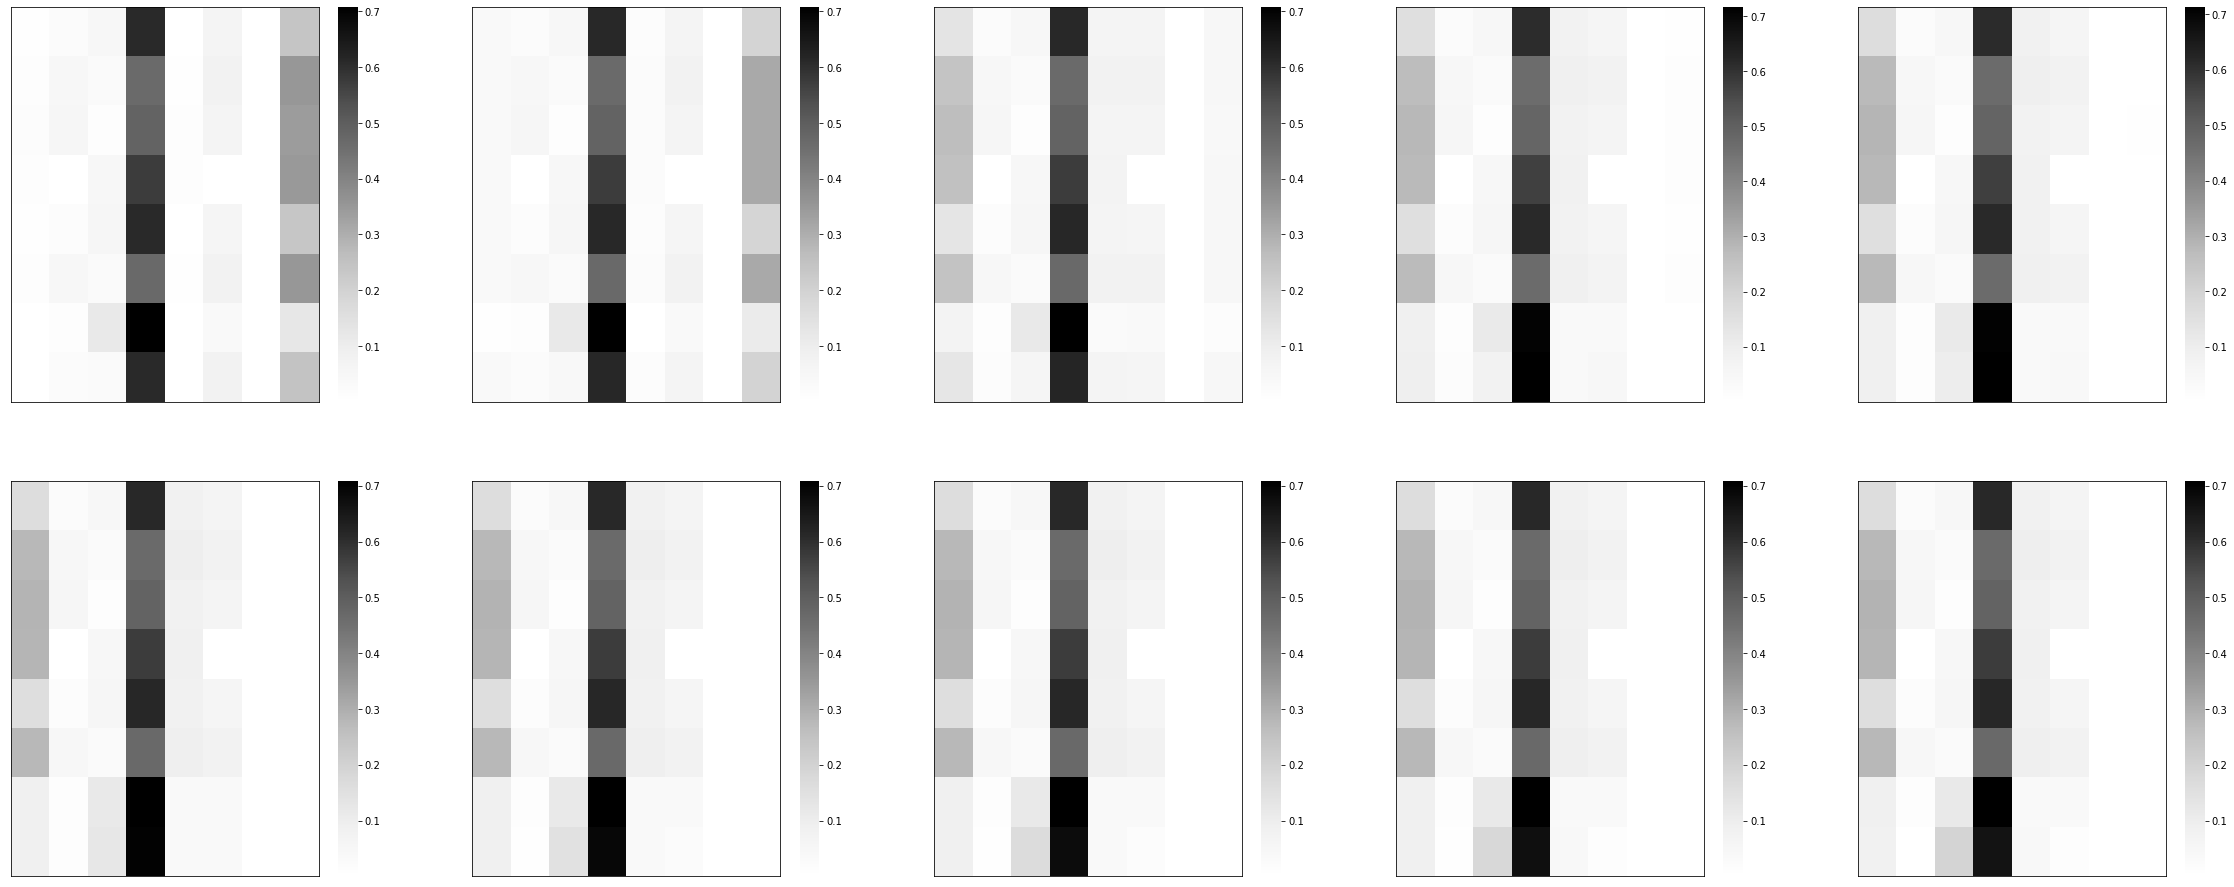

In [46]:
import copy
idx = 7
# losses = losses.cpu().detach()
print(list(losses.mean(0)))

sample = rangeBlock(10, losses.mean(0)[idx].item() - 3 * losses.std(0)[idx].item(), losses.mean(0)[idx].item() + 3 * losses.std(0)[idx].item())
vnet_T_type = 0


print(list(losses.std(0)))
print(list(sample))
result = []
net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, 29), map_location=torch.device("cpu")))
for i in sample:
    a = copy.deepcopy(losses.mean(0))
    a[idx] = i
    result.append(to_np(net(a, vnet_T_type=vnet_T_type)[1]))
result = np.concatenate(result)
drawHeatmap(result, fmt=False, col=5, p=False)


# Section B. Line Plot
### Contents
- B.0 Function
    - drawLinePlot : 라인 플롯 그리는 함수
- B.1 Psuedo Visualization
    - 임의의 샘플에 대한 라인 그래프 시각화
- B.2 Loss-Weight Visualization
    - MTN_auxi에 주어지는 loss에 따른 auxiliary Task들의 backward 그래프 생성
- B.3 Task Gradient Visualization
    - iter/epoch에 따른 auxiliary task들의 gradient 변화
    

### B.0 Function

In [3]:
def drawLinePlot(datas, index, col=1, title=[], xlabels=None, ylabels=None, markers=False, columns=None, p=False): # (G, D, T)
    
    if p:
        print("|- Parameter Information")
        print("  |- Data Info (G, D, C)")
        print("    |- G : Graph Num")
        print("    |- D : x data Num (Datas)")
        print("    |- C : y data Num (Column)")
        print("  |- Axis Info")
        print("    |- col   : 컬럼 갯수")
        print("    |- row : {}, col : {}".format(row, col))
        print("    |- height : {}, width : {}".format(row * 8, col * 8))
        print("    |- title : 컬럼별 제목")
        print("    |- p     : 정보 출력")
        print("  |- Graph Info")        
        print("    |- vmin/row  : 히트맵 최소/최대 값")
        print("    |- linecolor  : black, ...   ")
        print("    |- linewidths : 1.0...   ")
        print("    |- fmt        : 숫자 출력 소숫점 자릿 수")
        print("    |- cmap        : Grey")
        print("    |- cbar        : 오른쪽 바 On/Off")
        print("    |- xticklabels : x축 간격 (False, 1,2,...)")
        print("    |- yticklabels : y축 간격 (False, 1,2,...)")
        print()


        
    row = (len(datas) - 1) // col + 1
    title = title + list(range(len(title), len(datas) - len(title)))
    fig, axes = plt.subplots(nrows=row, ncols=col, squeeze=False)
    fig.set_size_inches(col * 8, row * 8)
    for e, data in enumerate(datas):
        ax = axes[e // col][e % col]
        d = pd.DataFrame(data, index=index, columns = columns).reset_index()
        d = d.melt(id_vars=["index"], value_vars=columns)
        p = sns.lineplot(x="index", y="value", data=d, hue="variable", markers=markers, ax=ax)
        p.set_xlabel(xlabels, fontsize=20)
        p.set_ylabel(ylabels, fontsize=20)

        ax.set(title=title[e])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()

### B.1 Psuedo Visualization

In [249]:
length = 20
graphs = 3
losses = torch.Tensor(rangeBlock(length, 0, 5, float, np)) # D
weight = np.expand_dims(makeSample((length, 8), 0 , 1, float, np), axis=0).repeat(graphs,0)
taskName = ["joint", "align", "mlm", "mfm", "m_joit", "m_align", "decoder", "m_decoder"]

print("data shape :", weight.shape)
print("index shape :", losses.shape)

drawLinePlot(weight, losses, columns=taskName, col=3) # (G, D, T)

TypeError: rangeBlock() takes from 1 to 3 positional arguments but 5 were given

### B.2 Loss-Weight Visualization

|- TASK INFORMATION
  |- TASK     :  RETRIEVAL
  |- DATATYPE :  YOUCOOK
data  shape :  (30, 20, 8)
xtick shape :  (20,)


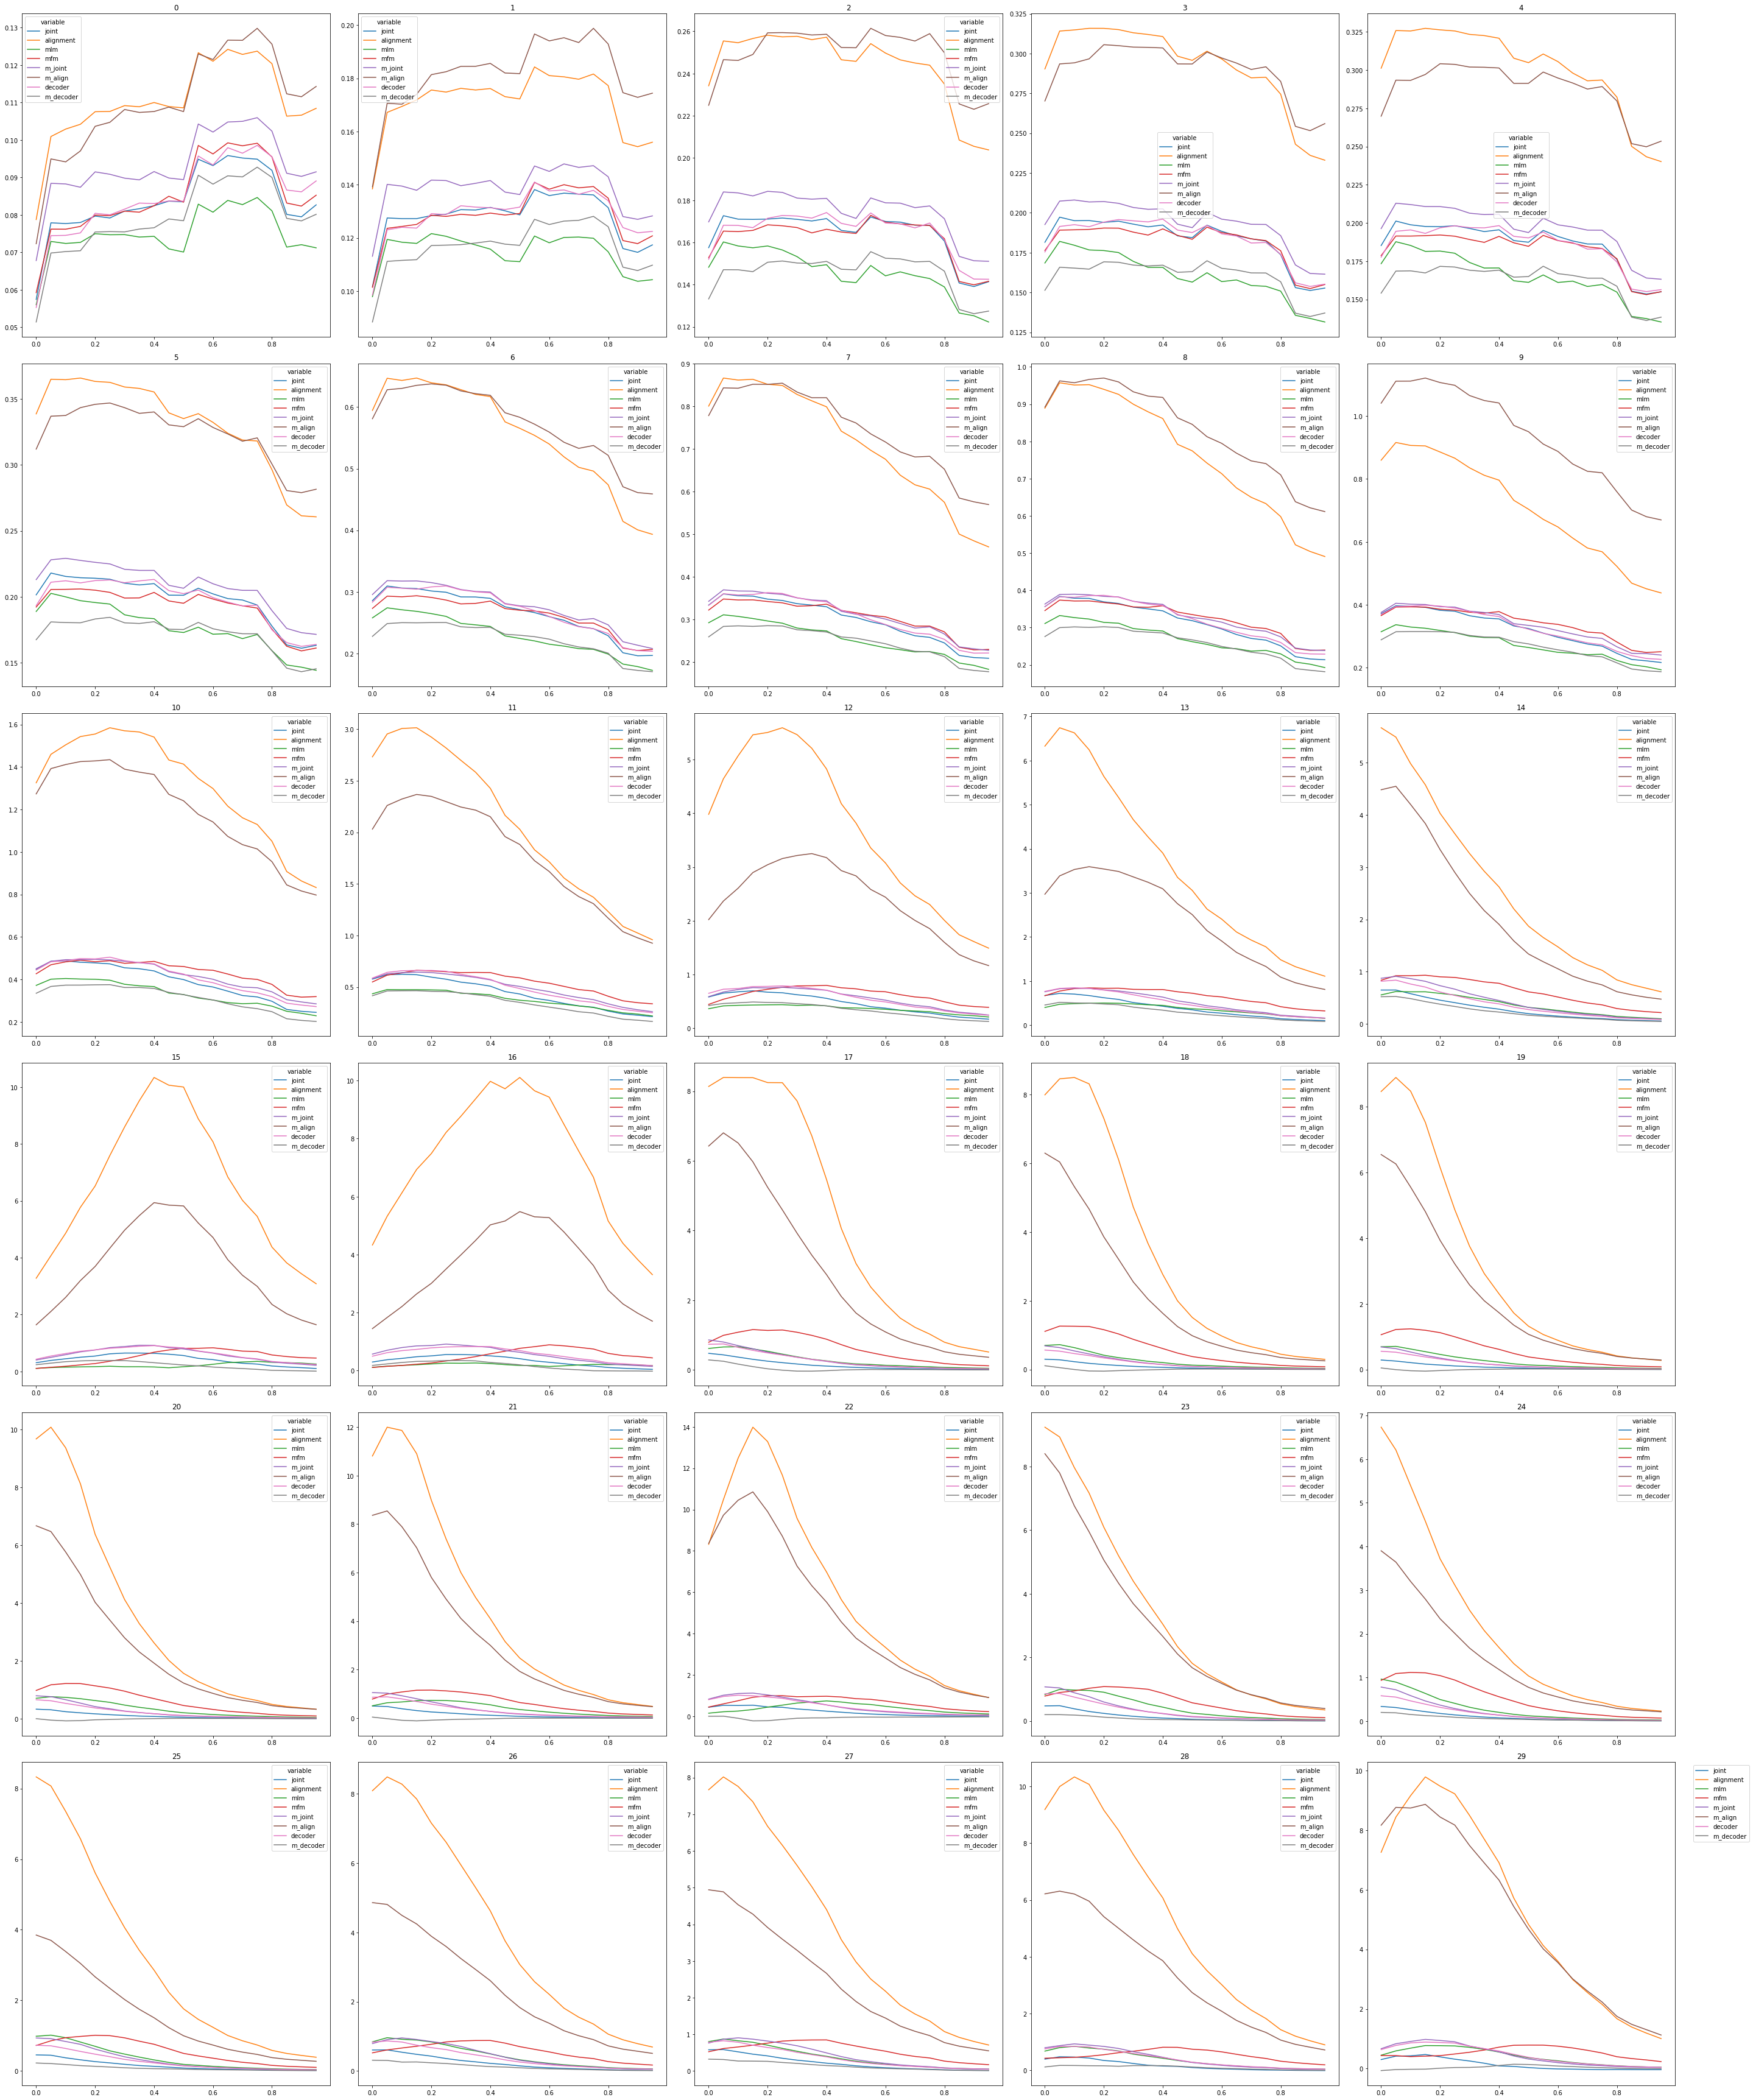

In [7]:
import math
# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files" # 1


# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_233135-23g43ptz/files" # 3
path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_003241-1l9gez5w/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_012812-fgit8yrf/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_022012-83khsjj3/files" # 20
# path= "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_031050-1lube4qe/files"    # 30
# path = "/data/project/rw/joonmyung/ANA:SCGEDYKER_YR/wandb/run-20220228_162617-36zqn5i6/files" # lr 고정 : 0.000015



# YOUCOOK CAPTIONING : 30 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_221616-zxvio0ox/files" # 3
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_232025-3gawigmq/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_001743-rugur5h7/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_020214-547r4gvc/files" # 30
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_025237-2x7xc70j/files"   # 100

# path = "/data/project/rw/joonmyung/ANA:SCHEDULE/wandb/run-20220227_222153-1qtdmf2w/files" # 고정

epochs = 30      # 최종 에포크 갯수
term =    1      # 보여줄 간격
view_type =   1  # [0 : 스텝 전체, 1 : 스텝 평균]
vnet_T_type = 3  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]
lmin, lmax, lblock = 0, 1, 20
re=True
info = getInfo(path, 0, p=True)
args= info["args"]
information(args)


net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()
losses = rangeBlock(lblock, lmin, lmax).unsqueeze(-1).repeat(1,8,1)
losses.requires_grad_(True)


result = []
for i in np.arange(0, epochs, term):
    net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, i), map_location=torch.device("cpu")))
    temps = []
    for loss in losses:
#         temps.append(np.log(to_np(torch.autograd.grad(net(loss)[0], loss, retain_graph=True, allow_unused=True)[0].t())))
        temps.append(to_np(torch.autograd.grad(net(loss, vnet_T_type=vnet_T_type)[0], loss, retain_graph=True, allow_unused=True)[0].t()))
    result.append(np.concatenate(temps, axis=0))
result = np.stack(result)

print("data  shape : ", result.shape)                  # (Graph, xTick, Task)
print("xtick shape : ", to_np(losses)[:,0,0].shape)    # (xTick, )

drawLinePlot(result, to_np(losses)[:,0,0], columns=args.taskName, col=5)
# 

### B.4 EPOCH-SCALE Visualization

In [50]:
import math
# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files" # 1

# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_233135-23g43ptz/files" # 3
path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_003241-1l9gez5w/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_012812-fgit8yrf/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_022012-83khsjj3/files" # 20
# path= "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_031050-1lube4qe/files"    # 30
# path = "/data/project/rw/joonmyung/ANA:SCGEDYKER_YR/wandb/run-20220228_162617-36zqn5i6/files" # lr 고정 : 0.000015





# YOUCOOK CAPTIONING : 30 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_221616-zxvio0ox/files" # 3
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_232025-3gawigmq/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_001743-rugur5h7/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_020214-547r4gvc/files" # 30
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_025237-2x7xc70j/files"   # 100


epochs = 40      # 최종 에포크 갯수
term =    1      # 보여줄 간격
length = 1
view_type =   0  # [0 : 스텝 전체, 1 : 스텝 평균]
vnet_T_type = 3  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]
loss_fix    = 0  # [0 : range,   1 : Fix]
re=True
info = getInfo(path, 0, p=True)
args= info["args"]
information(args)


net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()

if loss_fix:
    losses = torch.Tensor([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]).unsqueeze(1).unsqueeze(0) # (L, T, 1)
else:
    losses = rangeBlock(2, 3, 2).unsqueeze(-1).repeat(1,8,1) # (L, T, 1)
losses.requires_grad_(True)

result_a, result_l = [], []
for i in np.arange(0, epochs, length):
    net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, i), map_location=torch.device("cpu")))
    temps = []
    for loss in losses:
        temps.append(to_np(torch.autograd.grad(net(loss)[0], loss, retain_graph=True, allow_unused=True)[0].t()))
    if view_type:
        result_a.append(np.expand_dims(np.concatenate(temps, axis=0).mean(0), axis=0))            
        result_l.append(losses.mean(dim=0).squeeze())
    else:
        result_a.append(np.concatenate(temps, axis=0))
result = np.stack(result_a)
result = np.transpose(result, (1, 0, 2))
# print(result.shape) # (Graph, Xtick, Task)

|- TASK INFORMATION
  |- TASK     :  RETRIEVAL
  |- DATATYPE :  YOUCOOK


In [56]:
np.arange(0, epochs, length)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 40, 8)
(40,)


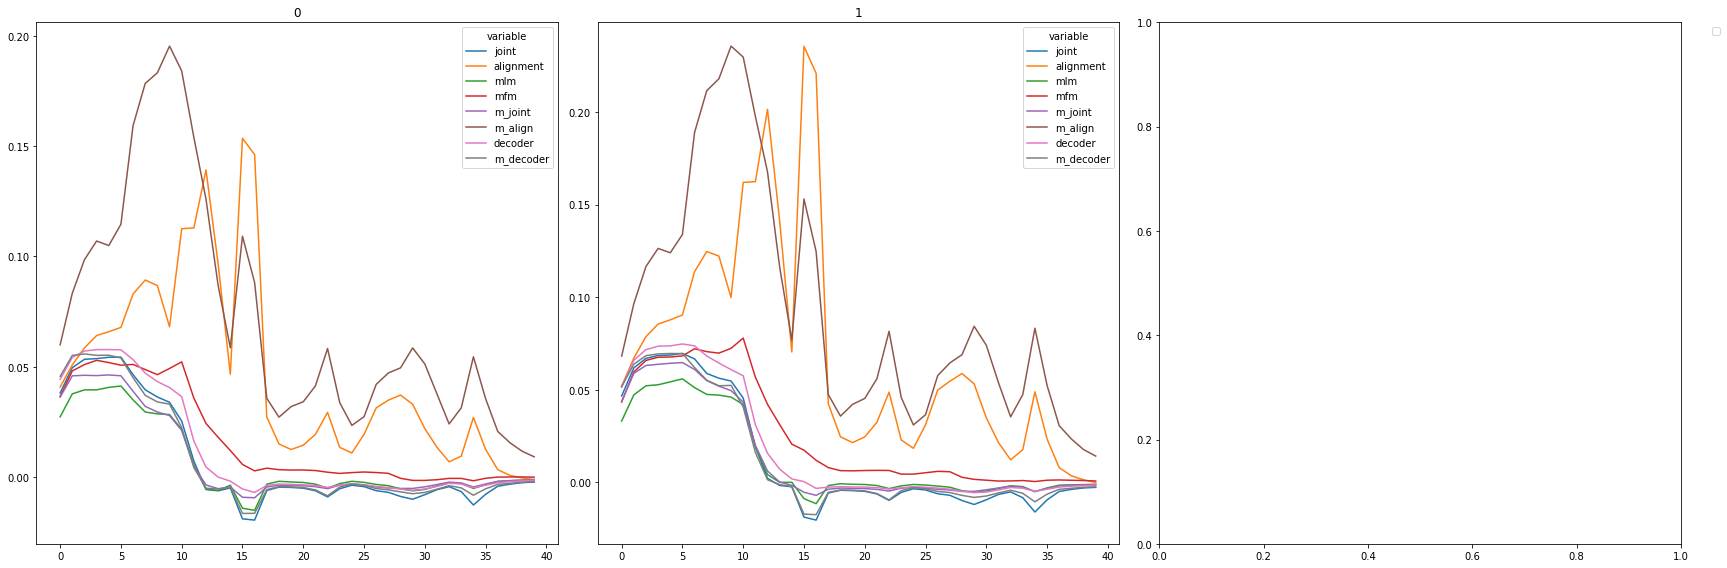

In [53]:
print(result.shape)
print(np.arange(0, epochs, length).shape)
# print(losses.shape)
drawLinePlot(result, np.arange(0, epochs, length), columns=args.taskName, col=3)

In [55]:
b = {"epoch": {"data":result[0], "loss": np.arange(0, epochs, length)} }

array([[ 3.81979644e-02,  4.08824906e-02,  2.73456536e-02,
         3.65486890e-02,  3.63094136e-02,  6.00075833e-02,
         4.43409383e-02,  4.56604734e-02],
       [ 4.96116355e-02,  5.08713834e-02,  3.77550460e-02,
         4.81528789e-02,  4.59295698e-02,  8.33612084e-02,
         5.42712100e-02,  5.51914014e-02],
       [ 5.34124970e-02,  5.85811883e-02,  3.95607539e-02,
         5.10309190e-02,  4.61617038e-02,  9.85474512e-02,
         5.71693927e-02,  5.58364913e-02],
       [ 5.37160672e-02,  6.41729608e-02,  3.95712443e-02,
         5.29454835e-02,  4.60271649e-02,  1.07017845e-01,
         5.77975139e-02,  5.52043989e-02],
       [ 5.43352515e-02,  6.59228638e-02,  4.06902432e-02,
         5.19283451e-02,  4.63213846e-02,  1.04947105e-01,
         5.78148440e-02,  5.52648678e-02],
       [ 5.43982871e-02,  6.78489506e-02,  4.12960202e-02,
         5.07292710e-02,  4.59398404e-02,  1.14602961e-01,
         5.77290021e-02,  5.40117882e-02],
       [ 4.64135930e-02,  8.300874

### B.3 Task Gradient Visualization

In [206]:
path = "/data/project/rw/joonmyung/ANA:SCHEDULER/wandb/run-20220227_220502-1lc9kww9/files" # 고정
info = getInfo(path, 0, p=True)
info.keys()

dict_keys(['atten_maps', 'args', 'task_grads', 'task_losses'])

|- TASK INFORMATION
  |- TASK     :  CAPTIONING
  |- DATATYPE :  YOUCOOK


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1, 100, 8)
100


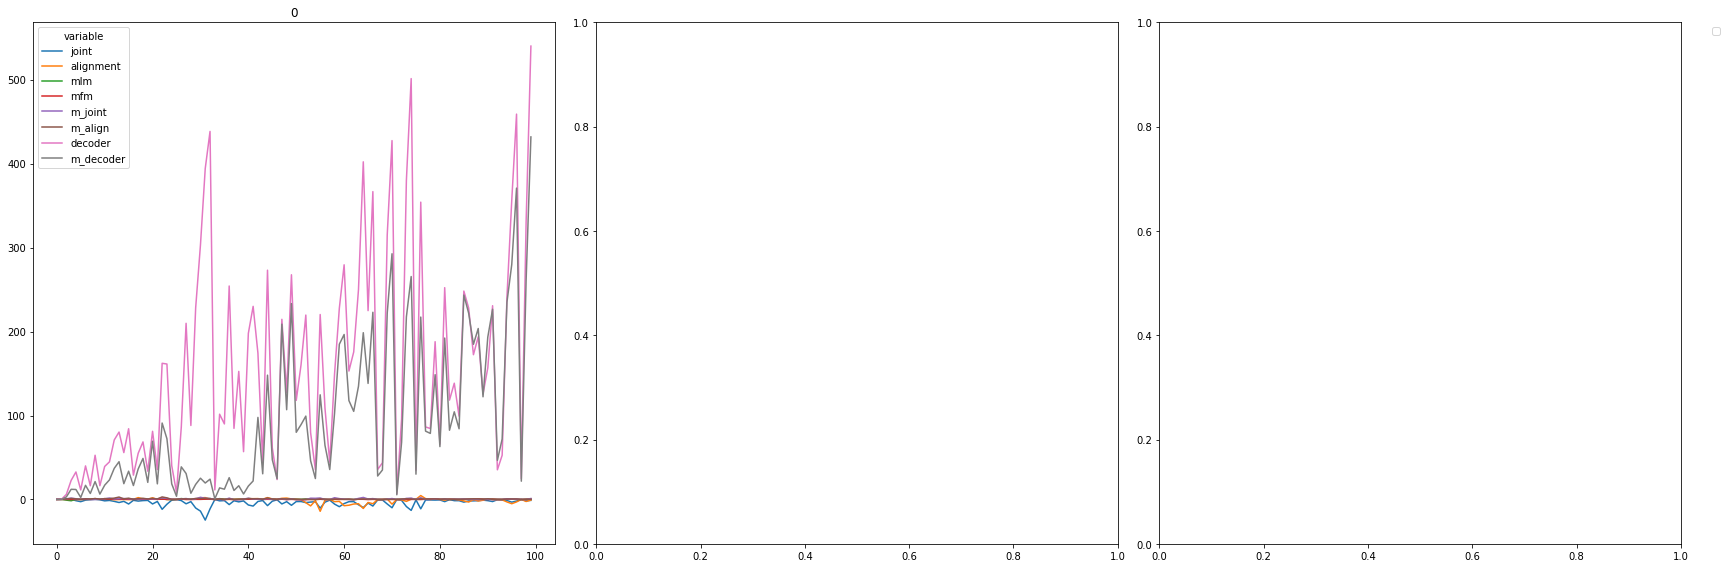

In [8]:
# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_233135-23g43ptz/files" # 3
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_003241-1l9gez5w/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_012812-fgit8yrf/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_022012-83khsjj3/files" # 20
# path= "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_031050-1lube4qe/files"    # 30
# path = "/data/project/rw/joonmyung/ANA:SCGEDYKER_YR/wandb/run-20220228_162617-36zqn5i6/files" # lr 고정 : 0.000015



# YOUCOOK CAPTIONING : 30 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files" # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_221616-zxvio0ox/files" # 3
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_232025-3gawigmq/files" # 5
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_001743-rugur5h7/files" # 10
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_020214-547r4gvc/files" # 30
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220228_025237-2x7xc70j/files"   # 100
path = "/data/project/rw/joonmyung/ANA:LR/wandb/run-20220228_053417-20egiqki/files"
path = "/data/project/rw/joonmyung/EX1.4.6/wandb/run-20220228_141850-3u1esjqw/files"
path = "/data/project/rw/joonmyung/EX1.4.6/wandb/run-20220228_141833-1wzflywe/files"
epochs = 100      # 최종 에포크 갯수
term =    1      # 보여줄 간격
view_type =   1  # [0 : 스텝 전체, 1 : 스텝 평균]
vnet_T_type = 3  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]
loss_fix    = 0  # [0 : range,   1 : Fix]
lmin, lmax, lrange = 0, 64, 1
re=True
info = getInfo(path, 0, p=True)
args= info["args"]
information(args)

net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()

if re:
    result_a, result_l = [], []
    for e in range(0, epochs, term):
        net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, e), map_location=torch.device("cpu")))
        info = getInfo(path, e)
        if loss_fix:
            losses = [torch.Tensor([1,1,2,2,3,3,1,1]).unsqueeze(1)]
        else:
            losses = torch.stack(info["task_losses"]).unsqueeze(-1)[range(lmin, lmax, lrange)]
            losses.requires_grad_(True)
        temps = []        
        for loss in losses:
            temps.append(to_np(torch.autograd.grad(net(loss, vnet_T_type=vnet_T_type)[0], loss, retain_graph=True, allow_unused=True)[0].t())) # → (1,8,8)
#             temps.append(np.log(to_np(torch.autograd.grad(net(loss, vnet_T_type=vnet_T_type)[0], loss, retain_graph=True, allow_unused=True)[0].t()))) # → (1,8,8)

        if view_type:
            result_a.append(np.expand_dims(np.concatenate(temps, axis=0).mean(0), axis=0))            
            result_l.append(losses.mean(dim=0).squeeze())
        else:
            result_a.append(np.concatenate(temps, axis=0))

    result_a = np.stack(result_a)
# print(result_a.shape) # (Graph, Xtick, Task), (30, 11, 8)
# print(len(range(lmin, lmax, lrange)))
# drawLinePlot(result_a[:,:,:], range(lmin, lmax, lrange), columns=args.taskName, col=3) # 

data_b = np.expand_dims(result_a[:,:,:], axis=0)
data_b = result_a.transpose(1,0,2)
loss_b = np.arange(0, epochs, term)
print(data_b.shape) # (Graph, Xtick, Task)
print(len(loss_b)) # (Graph, Xtick, Task)
drawLinePlot(data_b, loss_b, columns=args.taskName, col=3)

# Section C. HeatMap & Loss-Weight Visualization
### Contents
- C.0 Function
    - None
- C.1 Graph

### C.1 Graph

|- TASK INFORMATION
  |- TASK     :  CAPTIONING
  |- DATATYPE :  YOUCOOK
i_losses :  torch.Size([100, 1])
o_losses :  torch.Size([8, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


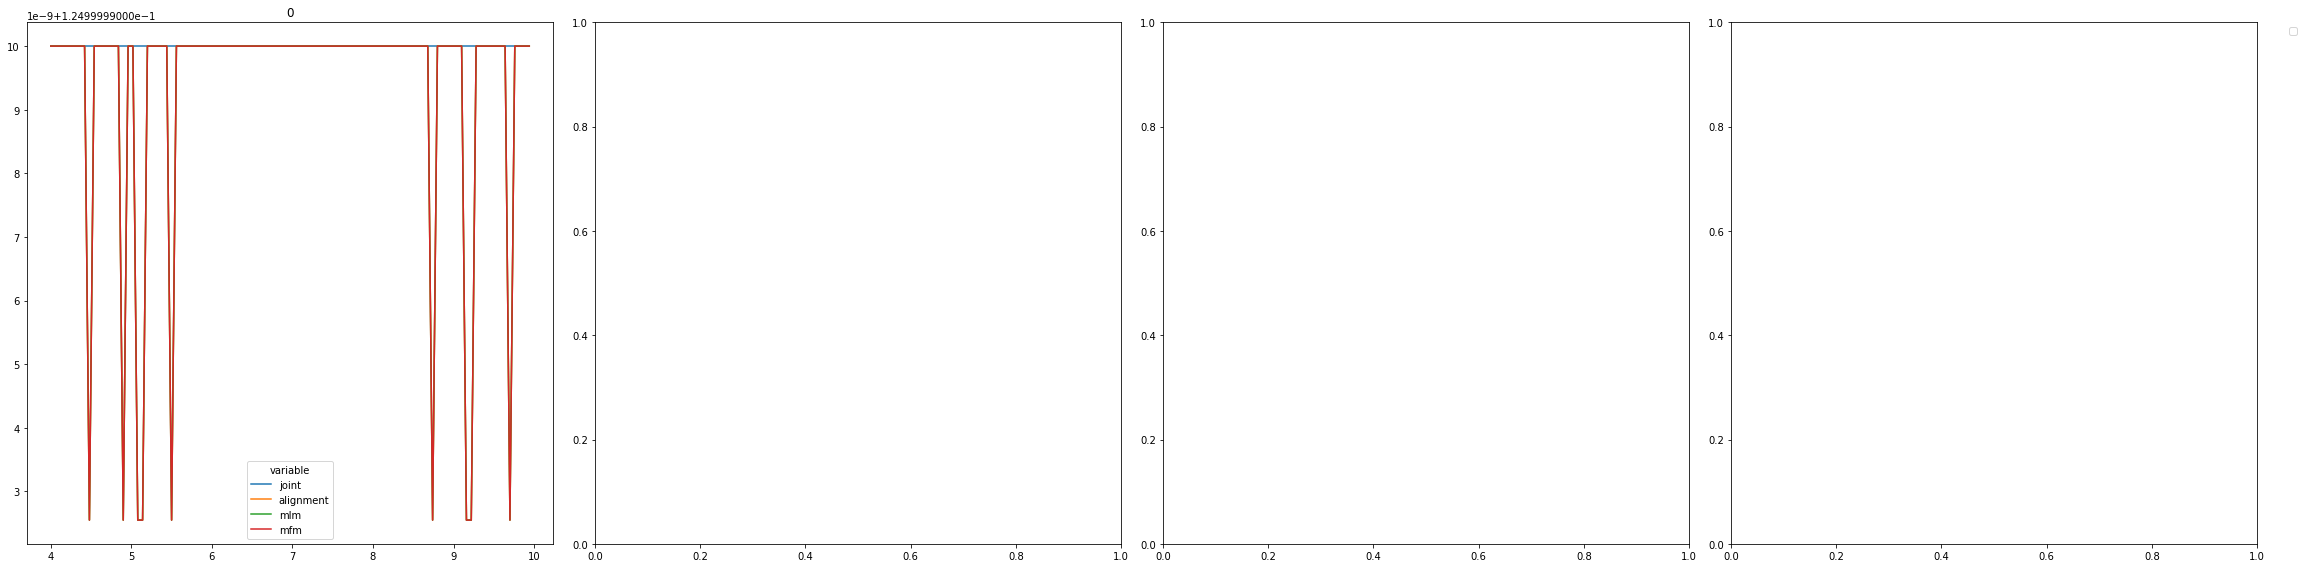

In [12]:
### SECTION A. Setting
# YOUCOOK RETRIEVAL  : 80 Epochs
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_205044-uf1v0lgu/files" # 1

# YOUCOOK CAPTIONING : 30 Epochs
path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_204521-1i1ohy9s/files"  # 1
# path = "/data/project/rw/joonmyung/ANA:ATTENTION/wandb/run-20220227_221616-zxvio0ox/files" # 3


# epochs = range(0,30) # 최종 에포크 갯수
epochs = [29]        # 에포크
c_e = 29             # 비교할 에포크
c_ts = [0, 1, 2, 3]  # 비교할 테스크

vnet_T_type = 0  # [0 : SCALE,   1 : TASK,   3 : SCALE + TASK]
loss_fix = 0  # [0 : range,     1 : 고정]
block, vmin, vmax = 100, 4, 10
re = True
info = getInfo(path, 0, p=True)
args = info["args"]
information(args)

net = MTN_auxi(t_dim=args.taskNum, f_dim=args.transformer_dim[0], i_dim=1, h1_dim=args.transformer_dim[1], h2_dim=args.transformer_dim[2], o_dim=1)
net.eval()

### SECTION B. SET Inputs, [Loss Block & Mean Losses]
with open("{}/info_{}.pickle".format(path, c_e), 'rb') as f:
    info = pickle.load(f)
i_losses = rangeBlock(block, vmin=vmin, vmax=vmax)
o_losses = torch.stack(info["task_losses"]).unsqueeze(-1).mean(0) # dummy

print("i_losses : ", i_losses.shape)  # [100, 8, 1] : [E, T, 1]
print("o_losses : ", o_losses.shape)  # [8, 1]      : [T, 1]

### SECTION C. Get Data
result_a, result_l = [[] for _ in range(len(c_ts))], []
for e in epochs:  # 에포크에 대해
    with torch.no_grad():
        net.load_state_dict(torch.load("{}/MTN_{}.pt".format(path, e), map_location=torch.device("cpu")))
        info = getInfo(path, e)
        for c_t in c_ts:  # Task에 대해
            o_losses = torch.stack(info["task_losses"]).unsqueeze(-1).mean(0)
            temps = []
            for loss in i_losses:  # Loss에 대해
                o_losses[c_t] = loss
                temps.append(to_np(net(o_losses, vnet_T_type=vnet_T_type)[1])[:,c_t].mean())  # (1,8,8) → 1
            result_a[c_t].append(np.array(temps))  # (L) → (L)
        result_a = np.concatenate(result_a, axis=0).transpose() # (4, 100) → (100, 4)
### SECTION D. Plotting
result_a = np.expand_dims(result_a, axis=0) # (1, 100, 4)

drawLinePlot(result_a, to_np(i_losses.squeeze()), columns=args.taskName[c_ts], col=len(c_ts))  # (G, D, T)
